* 教師なしで学習 全データ

In [2]:
import os
import logging
import resource
import pandas as pd
import numpy as np
import pickle

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from IOHMM import SemiSupervisedIOHMM
from IOHMM import CrossEntropyMNL, DiscreteMNL

In [6]:
# --- smoothing を加えた DiscreteMNL ---
class SmoothedDiscreteMNL(DiscreteMNL):
    def __init__(self, solver='lbfgs', alpha=1.0, **kw):
        super().__init__(solver=solver, **kw)
        self.alpha = alpha
    def predict_log_proba(self, X):
        logp = super().predict_log_proba(X)
        if self.alpha == 0:
            return logp 
        p = np.exp(logp)
        p += self.alpha
        p /= p.sum(axis=1, keepdims=True)
        return np.log(p)
    def loglike_per_sample(self, X, y):
        y_idx = y.ravel().astype(int)
        lp = self.predict_log_proba(X)
        return lp[np.arange(len(y_idx)), y_idx]

In [1]:
# train_iohmm_unsupervised.py
# 投球数が多い投手クラスタに対して教師なしIOHMMを学習・保存するスクリプト
import os
import logging
import resource
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from IOHMM import SemiSupervisedIOHMM
from IOHMM import CrossEntropyMNL, DiscreteMNL

# --- メモリ・CPU 制限設定 ---
def set_limits(max_mem_mb=None, max_cpu_sec=None):
    if max_mem_mb:
        mb = max_mem_mb * 1024 * 1024
        resource.setrlimit(resource.RLIMIT_AS, (mb, mb))
        logging.info(f"RLIMIT_AS={max_mem_mb}MB")
    if max_cpu_sec:
        resource.setrlimit(resource.RLIMIT_CPU, (max_cpu_sec, max_cpu_sec))
        logging.info(f"RLIMIT_CPU={max_cpu_sec}s")

# --- smoothing を加えた DiscreteMNL ---
class SmoothedDiscreteMNL(DiscreteMNL):
    def __init__(self, solver='lbfgs', alpha=1.0, **kw):
        super().__init__(solver=solver, **kw)
        self.alpha = alpha
    def predict_log_proba(self, X):
        logp = super().predict_log_proba(X)
        if self.alpha == 0:
            return logp 
        p = np.exp(logp)
        p += self.alpha
        p /= p.sum(axis=1, keepdims=True)
        return np.log(p)
    def loglike_per_sample(self, X, y):
        y_idx = y.ravel().astype(int)
        lp = self.predict_log_proba(X)
        return lp[np.arange(len(y_idx)), y_idx]

def prepare_dfs_unsupervised(df_p, test_size=0.2, random_state=42):
    req = ['balls','strikes','pitch_type','zone_cluster','pitch_cluster_label','zone','pitcher','game_pk']
    missing = [c for c in req if c not in df_p.columns]
    if missing:
        raise RuntimeError(f"Missing columns: {missing}")
    df = df_p.dropna(subset=['pitch_cluster_label','zone_cluster']).reset_index(drop=True)

    # ラベルエンコーダーを作成
    global le_zcl, le_z, le_pcl
    le_zcl = LabelEncoder().fit(df['zone_cluster'])
    le_z   = LabelEncoder().fit(df['zone'])
    le_pcl = LabelEncoder().fit(df['pitch_cluster_label'])

    # 数値変換
    df['zone_cluster']         = le_zcl.transform(df['zone_cluster'])
    df['zone']                 = le_z.transform(df['zone'])
    df['pitch_cluster_label']  = le_pcl.transform(df['pitch_cluster_label'])

    # ワンホット化（balls, strikes）
    all_combinations = [[b, s] for b in range(4) for s in range(3)]
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(all_combinations)
    X_ohe = ohe.transform(df[['balls','strikes']])
    input_features = ohe.get_feature_names_out(['balls','strikes'])
    df_ohe = pd.DataFrame(X_ohe, columns=input_features)
    df = pd.concat([df.reset_index(drop=True), df_ohe], axis=1)

    # シーケンス毎に分割
    seqs = {f"{p}_game_{g}": gdf.reset_index(drop=True)
            for (p, g), gdf in df.groupby(['pitcher','game_pk'])
            if len(gdf) >= 2}

    keys = list(seqs.keys())
    train_keys, test_keys = train_test_split(keys, test_size=test_size, random_state=random_state)
    dfs_train = [[seqs[k], {}] for k in train_keys]
    dfs_test  = [[seqs[k], {}] for k in test_keys]
    test_df   = pd.concat([seqs[k] for k in test_keys], axis=0, ignore_index=True)

    return dfs_train, dfs_test, test_df, ohe, input_features.tolist()

# --- モデル構築と学習（終了条件付きEM） ---
def build_and_train(dfs_train,
                    num_states,
                    input_features,
                    save_dir,
                    max_iter=500,
                    tol=1e-4):
    os.makedirs(save_dir, exist_ok=True)
    shmm = SemiSupervisedIOHMM(num_states=num_states,
                               EM_tol=tol,
                               max_EM_iter=max_iter)

    # --- 1) 共通のベース emission モデルを用意 ---
    em_pitch_base = SmoothedDiscreteMNL(solver='lbfgs', alpha=0,
                                        max_iter=max_iter, tol=tol)
    em_zone_base  = SmoothedDiscreteMNL(solver='lbfgs', alpha=0,
                                        max_iter=max_iter, tol=tol)

    # クラス数・特徴量数を取得
    n_pcl = len(le_pcl.classes_)
    n_zcl = len(le_zcl.classes_)
    n_feat = len(input_features)

    # 一様初期化
    em_pitch_base.coef_      = np.zeros((n_pcl, n_feat))
    em_pitch_base.intercept_ = np.log(np.ones(n_pcl) * (1.0 / n_pcl))

    em_zone_base.coef_       = np.zeros((n_zcl, n_feat))
    em_zone_base.intercept_  = np.log(np.ones(n_zcl) * (1.0 / n_zcl))

    # --- 2) flat list で set_models（内部で状態数分 deep-copy される） ---
    shmm.set_models(
        model_emissions=[em_pitch_base, em_zone_base],
        model_transition=CrossEntropyMNL(solver='lbfgs', max_iter=max_iter, tol=tol),
        model_initial=  CrossEntropyMNL(solver='lbfgs', max_iter=max_iter, tol=tol)
    )



    # --- 4) 入力・出力の設定および学習 ---
    shmm.set_inputs(
        covariates_initial=input_features,
        covariates_transition=input_features,
        covariates_emissions=[input_features, input_features]
    )
    shmm.set_outputs([['pitch_cluster_label'], ['zone_cluster']])
    shmm.set_data(dfs_train)

    shmm.train()

    # モデル保存
    with open(os.path.join(save_dir, 'model.pkl'), 'wb') as f:
        pickle.dump(shmm, f)
    logging.info(f"Saved model to {save_dir}/model.pkl | LL={shmm.log_likelihood:.4f}")


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    set_limits(max_mem_mb=32000)

    df_all = pd.read_csv('statcast_pitcher_clster.csv')

    dfs_train, dfs_test, test_df, ohe, input_features = prepare_dfs_unsupervised(df_all)
    out_dir = 'iohmm_allunsup'
    os.makedirs(out_dir, exist_ok=True)

    test_df.to_csv(os.path.join(out_dir, 'test_data.csv'), index=False)
    with open(os.path.join(out_dir, 'encoders.pkl'), 'wb') as f:
        pickle.dump({
            'le_zone_cluster': le_zcl,
            'le_zone': le_z,
            'le_pitch_cluster_label': le_pcl,
            'ohe_input': ohe,
            'input_features': input_features
        }, f)

    build_and_train(dfs_train,
                    num_states=6,
                    input_features=input_features,
                    save_dir=out_dir,
                    max_iter=400,
                    tol=1e-3)


2025-07-03 21:26:00,938 INFO RLIMIT_AS=32000MB
2025-07-03 21:40:14,510 INFO log likelihood of iteration 0: -8102094.0911
2025-07-03 21:51:37,315 INFO log likelihood of iteration 1: -8102103.8814
2025-07-03 22:03:10,610 INFO log likelihood of iteration 2: -8102096.0323
2025-07-03 22:13:23,456 INFO log likelihood of iteration 3: -8102102.2921
2025-07-03 22:23:20,604 INFO log likelihood of iteration 4: -8102069.5066
2025-07-03 22:33:56,779 INFO log likelihood of iteration 5: -8102059.9770
2025-07-03 22:45:06,047 INFO log likelihood of iteration 6: -8101966.6795
2025-07-03 22:55:45,291 INFO log likelihood of iteration 7: -8101782.6555
2025-07-03 23:06:17,788 INFO log likelihood of iteration 8: -8101389.4961
2025-07-03 23:17:07,501 INFO log likelihood of iteration 9: -8100516.4192
2025-07-03 23:28:25,137 INFO log likelihood of iteration 10: -8098842.9776
2025-07-03 23:39:28,768 INFO log likelihood of iteration 11: -8095207.7725
2025-07-03 23:49:52,949 INFO log likelihood of iteration 12: -8

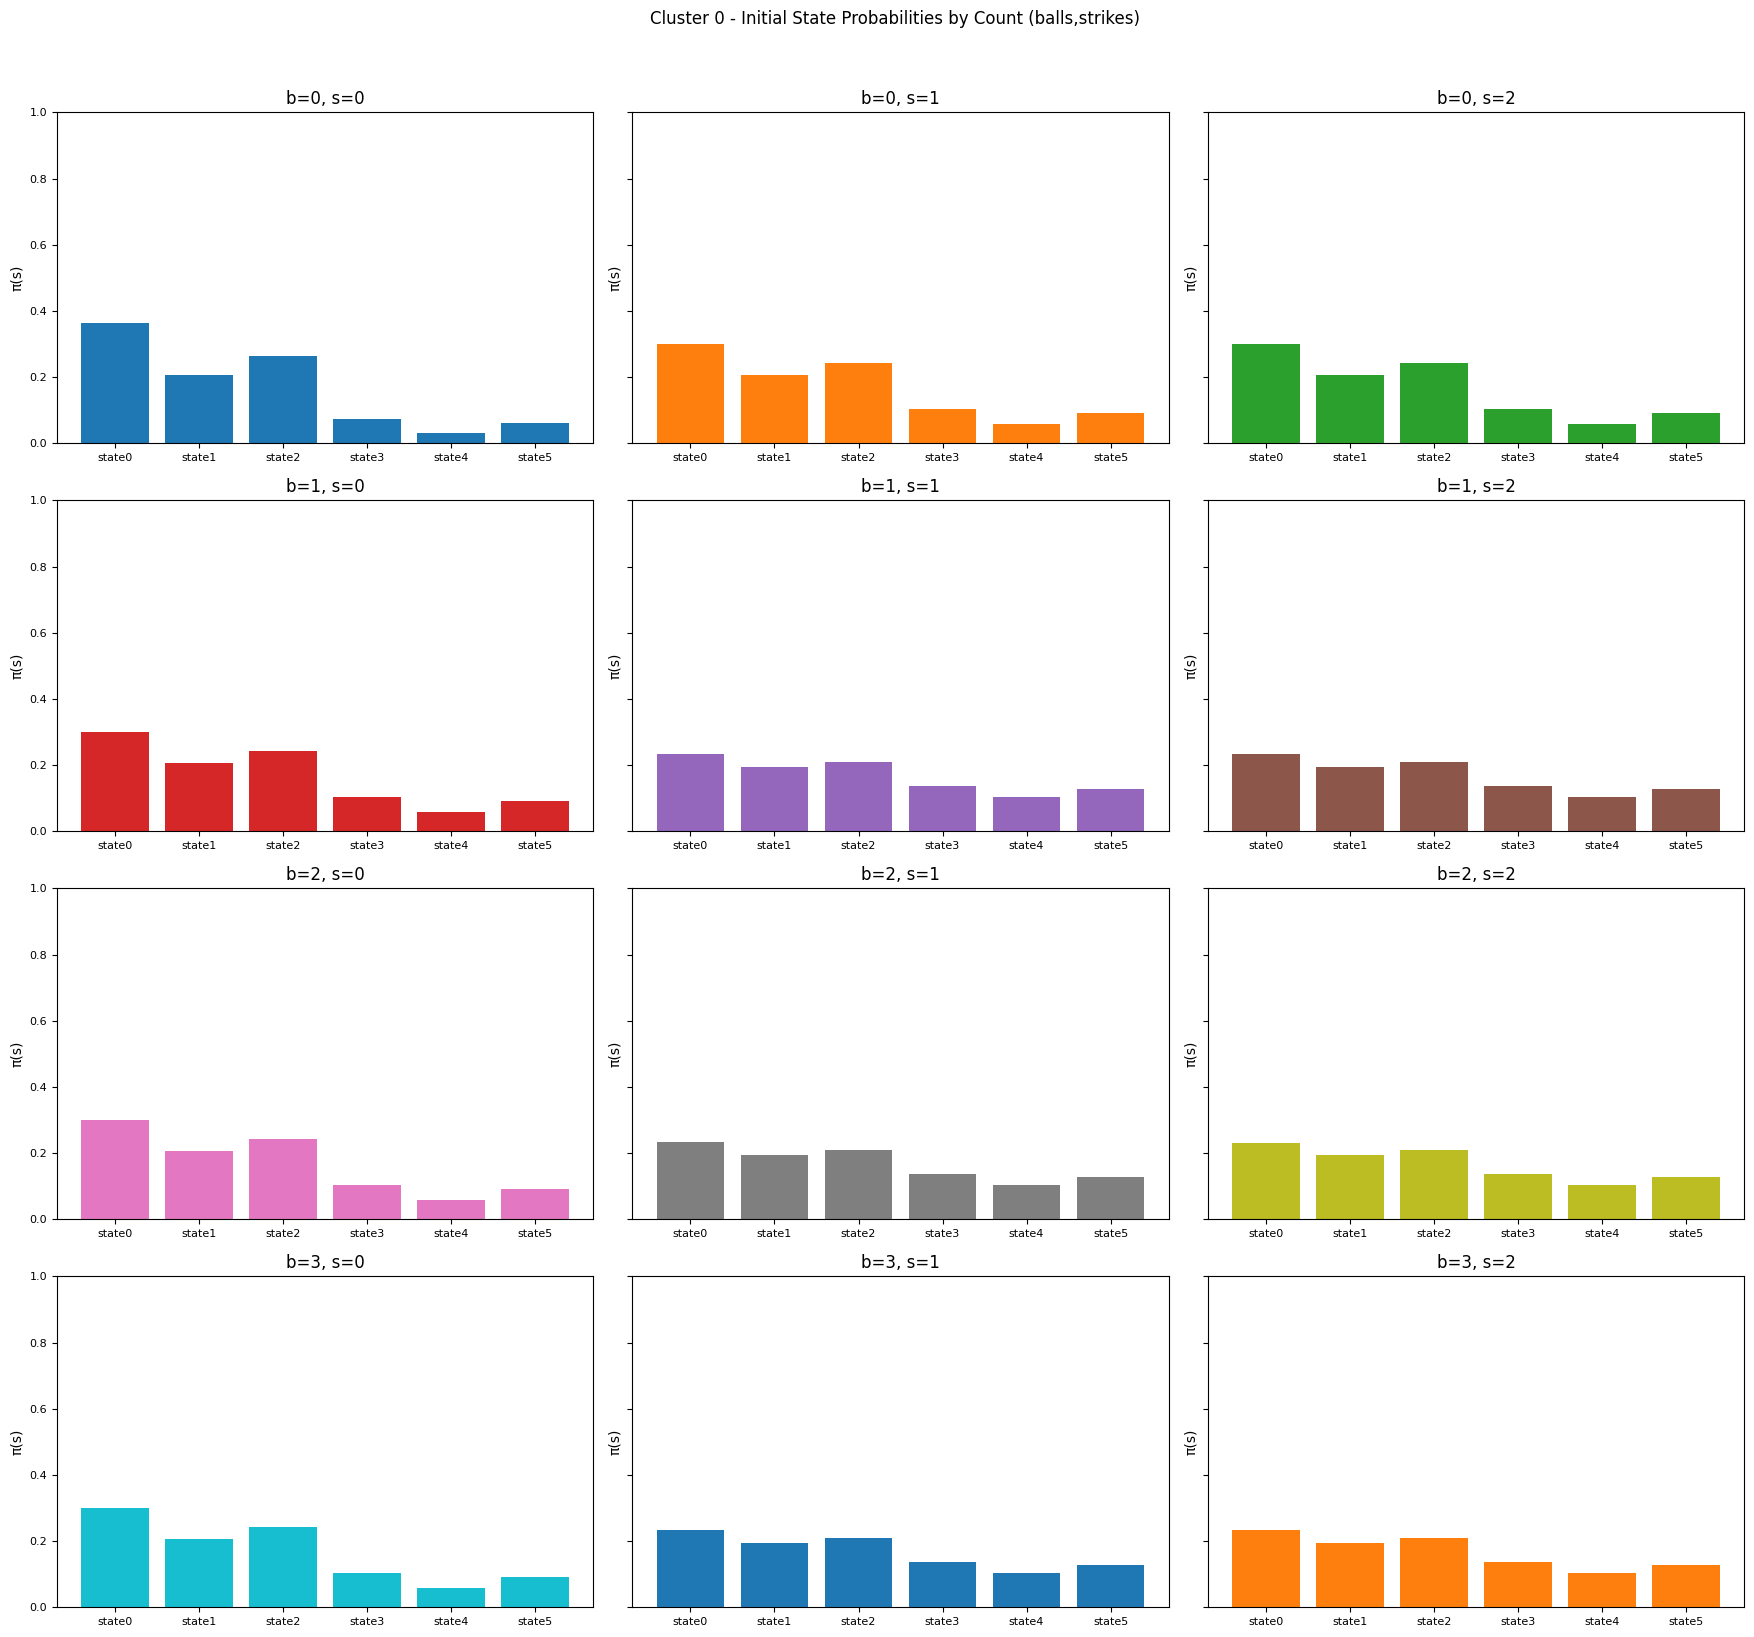

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# クラスタ番号のリスト（必要なクラスタを指定）
cluster_list = [0]  # 必要に応じて変更

# balls-strikes 全組み合わせ
covs = [(b, s) for b in range(4) for s in range(3)]
n_cov = len(covs)
n_cols = 3
n_rows = ceil(n_cov / n_cols)

for cluster in cluster_list:
    model_dir = f"iohmm_allunsup"
    model_fp  = os.path.join(model_dir, "model.pkl")
    enc_fp    = os.path.join(model_dir, "encoders.pkl")

    if not os.path.isfile(model_fp) or not os.path.isfile(enc_fp):
        print(f"[Cluster {cluster}] モデルまたはエンコーダが見つかりません。スキップします。")
        continue

    with open(model_fp, "rb") as mf:
        shmm_loaded = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    # 隠れ状態ID と表示ラベルを用意
    state_ids    = np.arange(shmm_loaded.num_states)
    state_labels = [f"state{st}" for st in state_ids]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Cluster {cluster} - Initial State Probabilities by Count (balls,strikes)", y=1.02)

    for idx, (b, s) in enumerate(covs):
        ax = axes[idx]
        # one-hot に変換して π(s) を取得
        x_input = encs["ohe_input"].transform([[b, s]])
        log_pi  = shmm_loaded.model_initial.predict_log_proba(x_input)[0]
        pi      = np.exp(log_pi)

        # プロット
        ax.bar(state_ids, pi, color=f"C{idx % 10}")
        ax.set_title(f"b={b}, s={s}", fontsize=12)
        ax.set_xticks(state_ids)
        ax.set_xticklabels(state_labels, rotation=0, fontsize=8)
        ax.set_ylabel("π(s)", fontsize=10)
        ax.set_ylim(0, 1.0)
        ax.yaxis.set_tick_params(labelsize=8)

    # 余ったサブプロットを非表示に
    for j in range(n_cov, n_rows * n_cols):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0, 0.98, 1.00])
    plt.show()


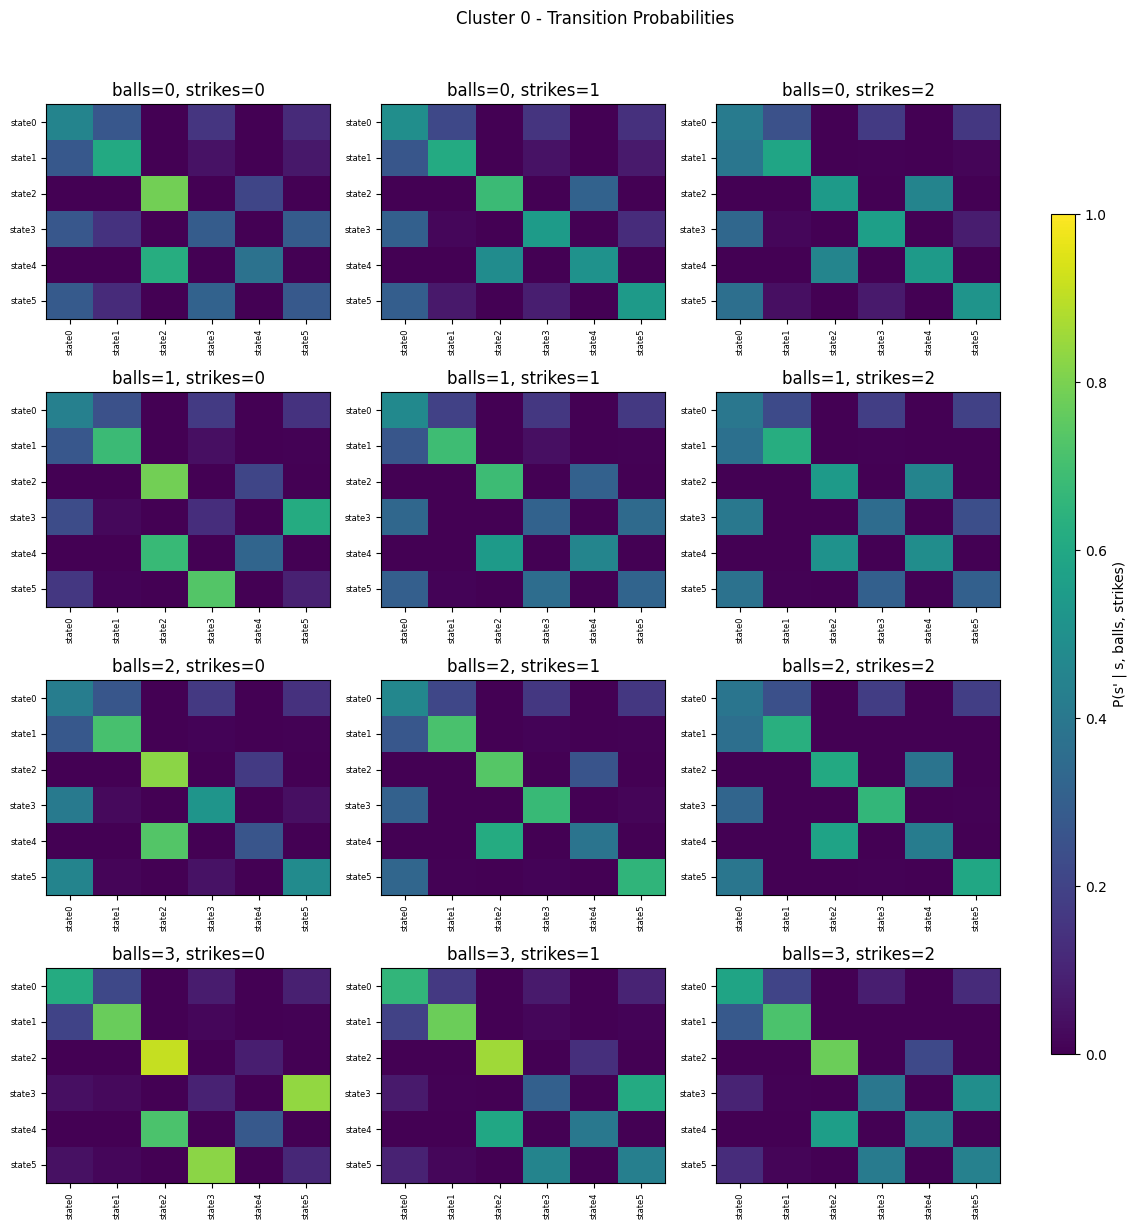

In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# クラスタ番号のリスト（必要に応じて変更）
cluster_list = [0]  # すべてやりたいときは range(29) など

# balls-strikes の全組み合わせ
covs = [(b, s) for b in range(4) for s in range(3)]  # 4×3 = 12パターン

for cluster in cluster_list:
    model_dir = f"iohmm_allunsup"
    model_fp = os.path.join(model_dir, "model.pkl")
    enc_fp   = os.path.join(model_dir, "encoders.pkl")

    if not os.path.isfile(model_fp):
        print(f"[Cluster {cluster}] モデルファイルが見つかりません ({model_fp})")
        continue
    if not os.path.exists(enc_fp):
        print(f"[Cluster {cluster}] エンコーダーファイルが見つかりません: {enc_fp}")
        continue

    with open(model_fp, "rb") as mf:
        shmm_loaded = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    # 隠れ状態のID と表示ラベル
    n_states    = shmm_loaded.num_states
    state_ids   = np.arange(n_states)
    state_labels = [f"state{st}" for st in state_ids]

    # グリッド図
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    fig.suptitle(f"Cluster {cluster} - Transition Probabilities", y=1.02)

    for idx, (b, s) in enumerate(covs):
        ax = axes.flat[idx]

        x_input = encs["ohe_input"].transform([[b, s]])  # 条件をone-hotでエンコード

        # 各状態から次状態への遷移確率
        trans_mat = np.vstack([
            np.exp(shmm_loaded.model_transition[st].predict_log_proba(x_input))
            for st in state_ids
        ])

        im = ax.imshow(trans_mat, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        ax.set_title(f"balls={b}, strikes={s}")
        ax.set_xticks(state_ids)
        ax.set_yticks(state_ids)
        # X/Y 共に隠れ状態ラベルを表示
        ax.set_xticklabels(state_labels, rotation=90, fontsize=6)
        ax.set_yticklabels(state_labels,           fontsize=6)

    # 共通カラーバー
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(s' | s, balls, strikes)")
    plt.tight_layout(rect=[0, 0, 0.85, 1.0])
    plt.show()


In [4]:
import matplotlib.font_manager as fm

for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if 'ipag' in font.lower() or 'noto' in font.lower():
        print(font)


/usr/share/fonts/opentype/noto/NotoSansCJK-Thin.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Black.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Black.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-Medium.ttc
/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Light.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc
/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc
/usr/share/fonts/truetype/noto/NotoSansMono-Bold.ttf
/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc
/usr/share/fonts/truetype/no

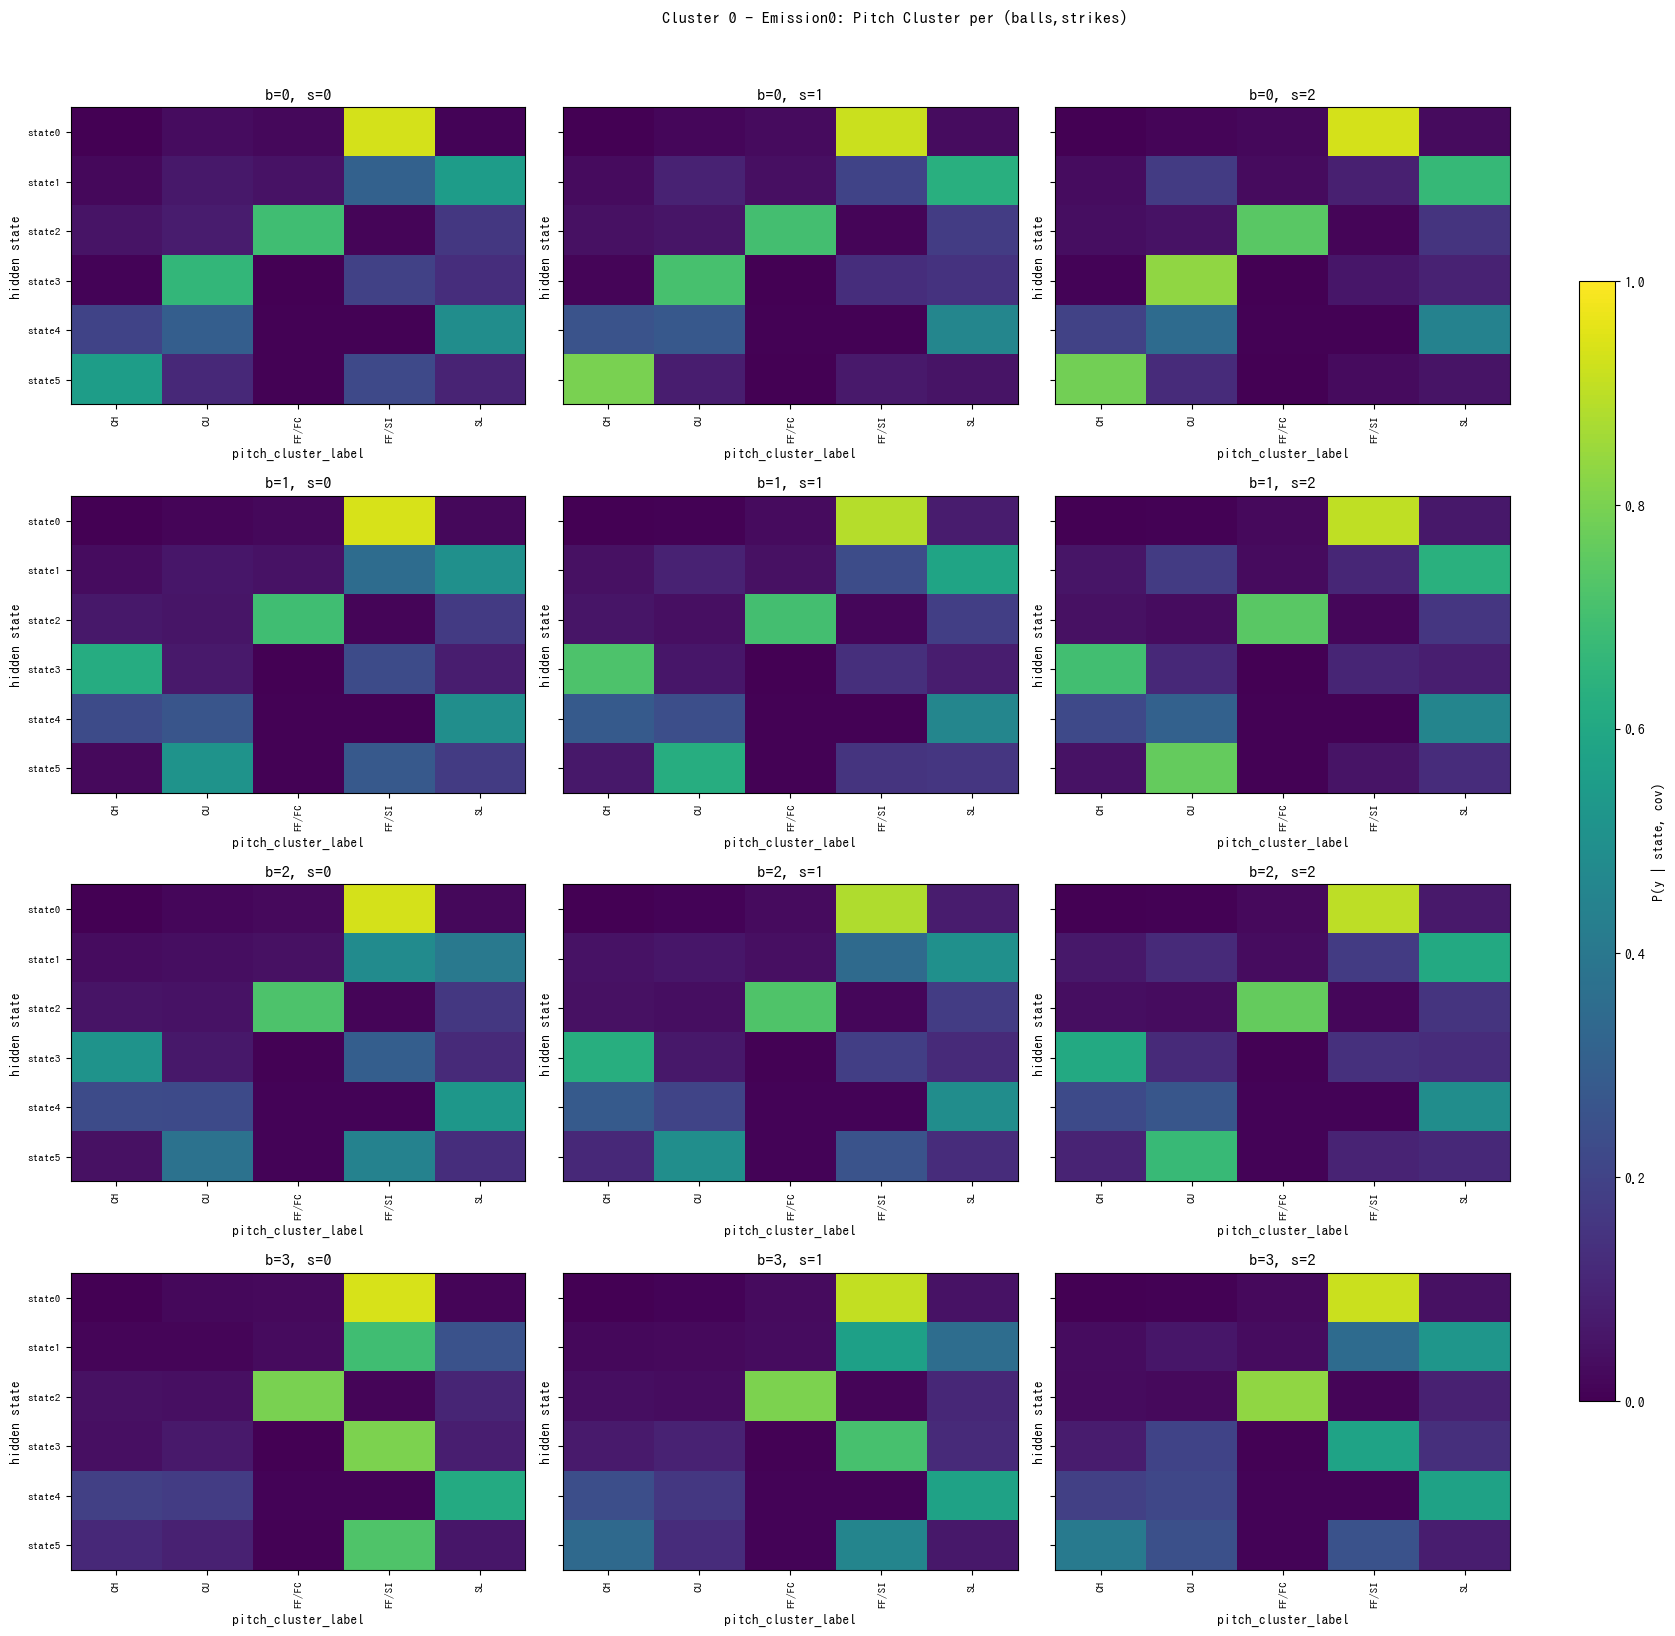

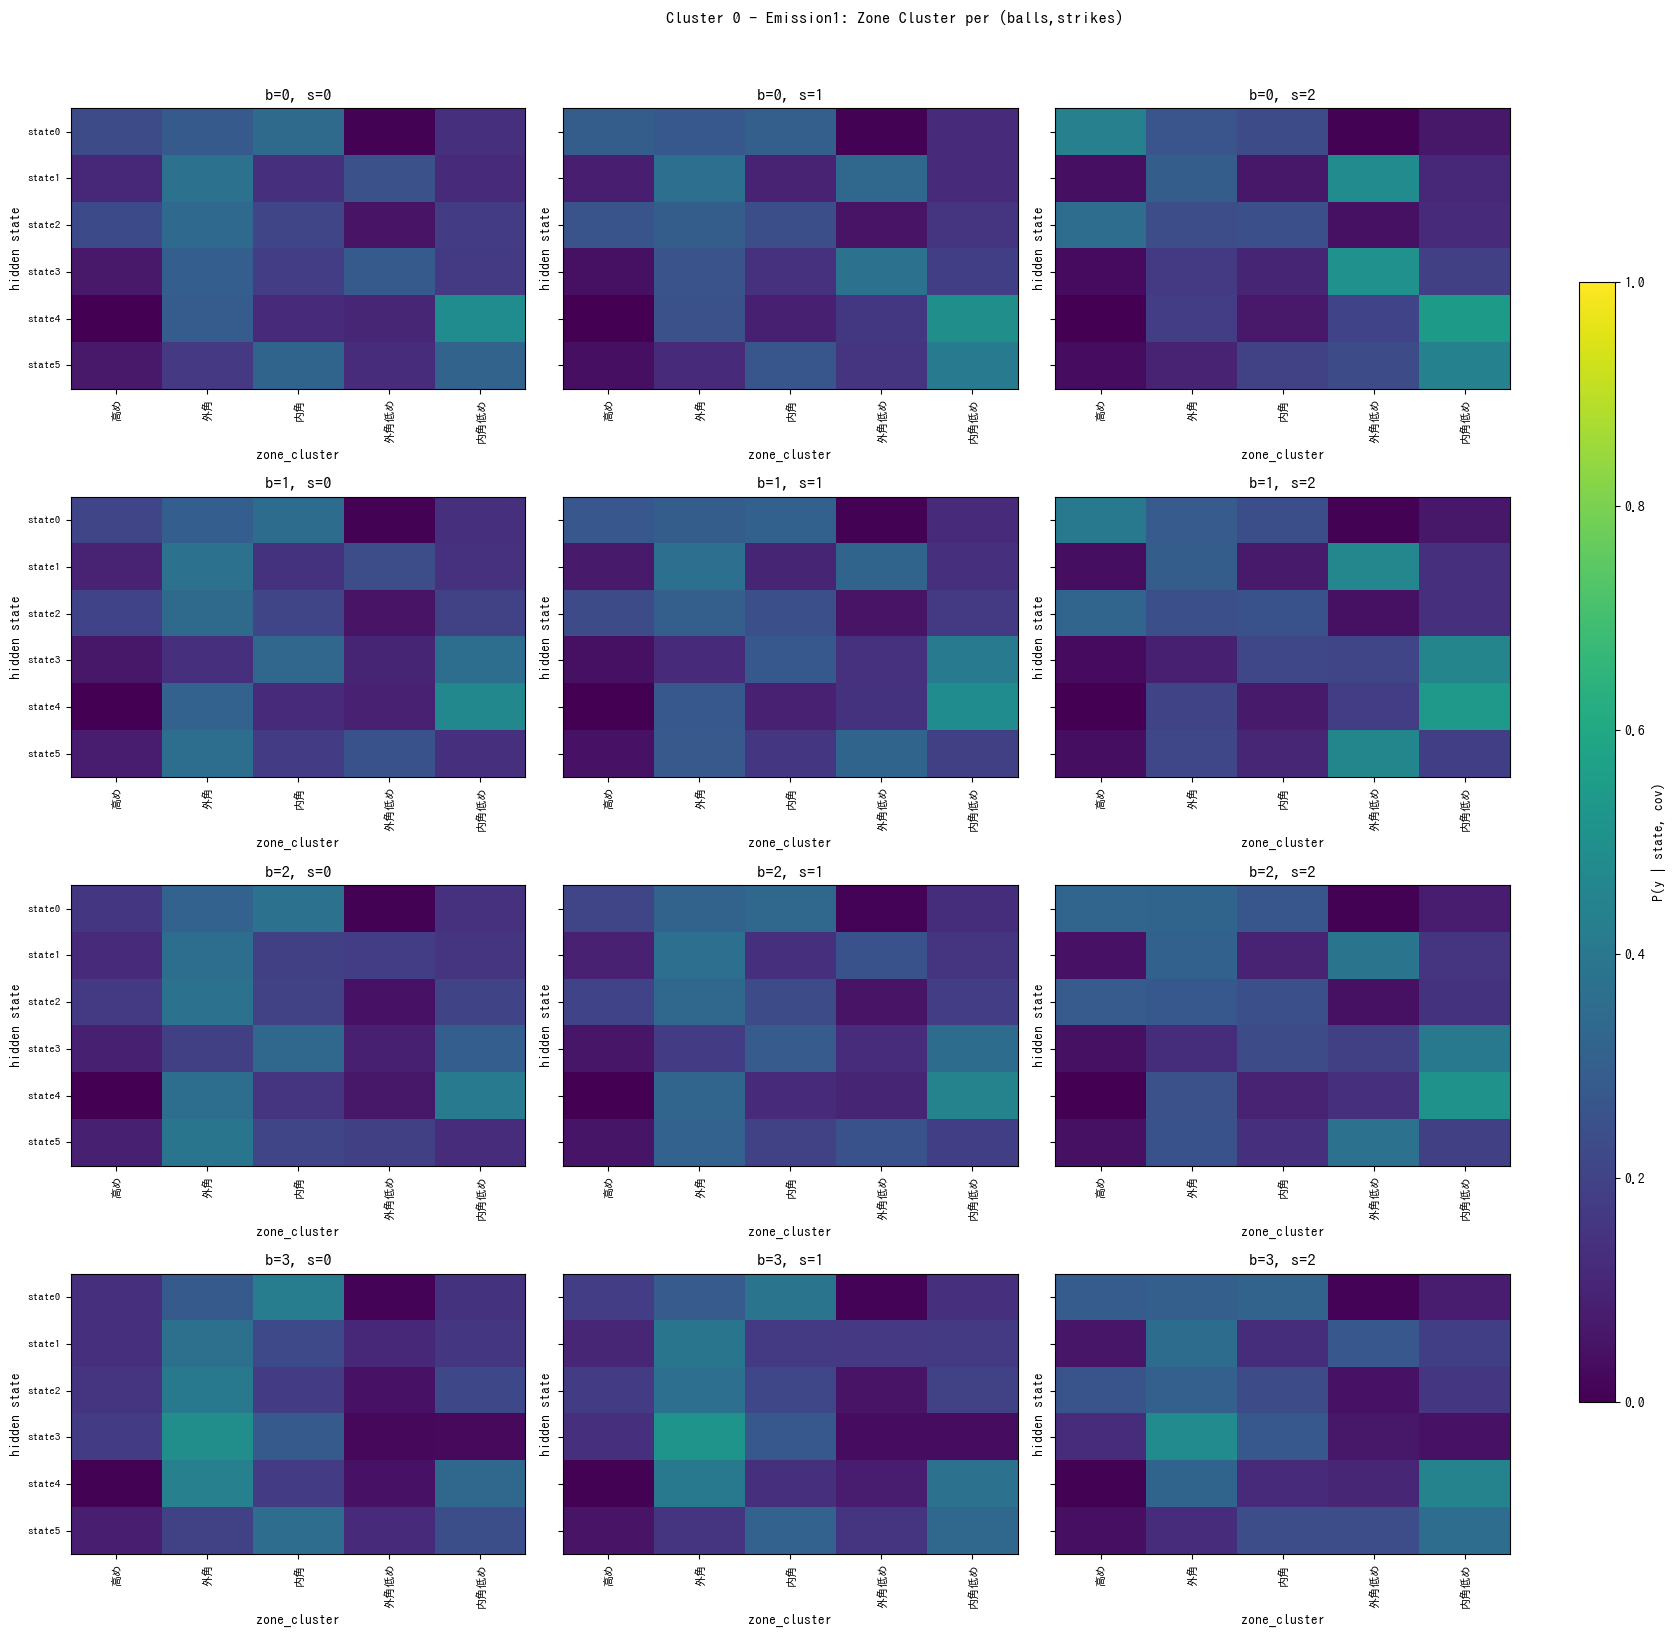

In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import ceil
from matplotlib import font_manager as fm

# --- 日本語フォント設定（お好みで） ---
font_path = "/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf"
jp_font = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = jp_font.get_name()
plt.rcParams['axes.unicode_minus'] = False

# クラスタリスト（任意で調整）
cluster_list = [0]

# balls-strikes 全パターン
covs   = [(b, s) for b in range(4) for s in range(3)]
n_cov  = len(covs)
n_cols = 3
n_rows = ceil(n_cov / n_cols)

for cluster in cluster_list:
    model_dir = f"iohmm_allunsup"
    model_fp  = os.path.join(model_dir, "model.pkl")
    enc_fp    = os.path.join(model_dir, "encoders.pkl")

    if not os.path.isfile(model_fp) or not os.path.isfile(enc_fp):
        print(f"[Cluster {cluster}] モデルまたはエンコーダが見つかりません。スキップします。")
        continue

    # モデルとエンコーダ読み込み
    with open(model_fp, "rb") as mf:
        shmm = pickle.load(mf)
    with open(enc_fp, "rb") as ef:
        encs = pickle.load(ef)

    # ラベル類の準備
    ohe         = encs["ohe_input"]
    pcl_labels  = encs["le_pitch_cluster_label"].inverse_transform(np.arange(len(encs["le_pitch_cluster_label"].classes_)))
    zone_map    = {0:"高め",1:"外角",2:"内角",3:"外角低め",4:"内角低め"}
    zcl_labels  = encs["le_zone_cluster"].inverse_transform(np.arange(len(encs["le_zone_cluster"].classes_)))
    zcl_names   = [zone_map[int(lbl)] for lbl in zcl_labels]
    # ← ここで隠れ状態ラベルを作成
    state_ids   = np.arange(shmm.num_states)
    state_labels= [f"state{st}" for st in state_ids]

    # --- Emission0: pitch_cluster_label ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Cluster {cluster} - Emission0: Pitch Cluster per (balls,strikes)", y=1.02)

    for i, (b, s) in enumerate(covs):
        ax = axes[i]
        x_input = ohe.transform([[b, s]])

        # 各隠れ状態ごとの emission 確率行列を作成
        emis0 = np.vstack([
            np.exp(shmm.model_emissions[state][0].predict_log_proba(x_input)[0])
            for state in state_ids
        ])

        im = ax.imshow(emis0, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        ax.set_title(f"b={b}, s={s}")
        # X 軸：pitch_cluster_label
        ax.set_xticks(range(len(pcl_labels)))
        ax.set_xticklabels(pcl_labels, rotation=90, fontsize=8)
        # Y 軸：隠れ状態
        ax.set_yticks(state_ids)
        ax.set_yticklabels(state_labels, fontsize=8)
        ax.set_xlabel("pitch_cluster_label")
        ax.set_ylabel("hidden state")

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(y | state, cov)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()

    # --- Emission1: zone_cluster ---
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows), sharey=True)
    axes = axes.flatten()
    fig.suptitle(f"Cluster {cluster} - Emission1: Zone Cluster per (balls,strikes)", y=1.02)

    for i, (b, s) in enumerate(covs):
        ax = axes[i]
        x_input = ohe.transform([[b, s]])

        emis1 = np.vstack([
            np.exp(shmm.model_emissions[state][1].predict_log_proba(x_input)[0])
            for state in state_ids
        ])

        im = ax.imshow(emis1, vmin=0, vmax=1, aspect='auto', cmap=cm.viridis)
        ax.set_title(f"b={b}, s={s}")
        # X 軸：zone_cluster
        ax.set_xticks(range(len(zcl_names)))
        ax.set_xticklabels(zcl_names, rotation=90, fontsize=8)
        # Y 軸：隠れ状態
        ax.set_yticks(state_ids)
        ax.set_yticklabels(state_labels, fontsize=8)
        ax.set_xlabel("zone_cluster")
        ax.set_ylabel("hidden state")

    for j in range(n_cov, len(axes)):
        axes[j].axis("off")

    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="P(y | state, cov)")
    plt.tight_layout(rect=[0,0,0.85,1.0])
    plt.show()


In [6]:

import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# 評価対象のクラスタリスト（必要に応じて調整）
cluster_list = [0]

for cluster in cluster_list:
    dir_name = f"iohmm_allunsup"
    model_file = os.path.join(dir_name, 'model.pkl')
    test_file  = os.path.join(dir_name, 'test_data.csv')
    enc_file   = os.path.join(dir_name, 'encoders.pkl')

    if not all(os.path.exists(p) for p in [model_file, test_file, enc_file]):
        print(f"[Cluster {cluster}] ファイルが揃っていません。スキップします。")
        continue

    with open(model_file, 'rb') as mf:
        shmm = pickle.load(mf)
    df_test = pd.read_csv(test_file)
    with open(enc_file, 'rb') as ef:
        encs = pickle.load(ef)

    le_z   = encs['le_zone']
    le_pcl = encs['le_pitch_cluster_label']
    le_zcl = encs['le_zone_cluster']
    ohe    = encs['ohe_input']

    # game_pk ごとに系列を作成
    test_dfs = []
    for _, seq_df in df_test.groupby('game_pk'):
        seq = seq_df.reset_index(drop=True)
        test_dfs.append([seq, {}])

    shmm.set_data(test_dfs)
    shmm.E_step()
    posterior_paths = [np.argmax(logg, axis=1) for logg in shmm.log_gammas]

    hidden_true, hidden_pred = [], []
    true_p, pred_p = [], []
    true_z, pred_z = [], []

    for (df, _), path in zip(test_dfs, posterior_paths):
        hidden_true.extend(df['zone'].astype(int).values)
        hidden_pred.extend(path)

        X = ohe.transform(df[['balls','strikes']])
        true_p.append(df['pitch_cluster_label'].values)
        true_z.append(df['zone_cluster'].values)

        pred_p_seq, pred_z_seq = [], []
        for t, s in enumerate(path):
            logp0 = shmm.model_emissions[s][0].predict_log_proba(X[t].reshape(1,-1))
            pred_p_seq.append(int(np.argmax(np.exp(logp0))))

            logp1 = shmm.model_emissions[s][1].predict_log_proba(X[t].reshape(1,-1))
            pred_z_seq.append(int(np.argmax(np.exp(logp1))))

        pred_p.append(np.array(pred_p_seq))
        pred_z.append(np.array(pred_z_seq))

    hidden_true = np.array(hidden_true)
    hidden_pred = np.array(hidden_pred)
    y_true_p = np.hstack(true_p)
    y_pred_p = np.hstack(pred_p)
    y_true_z = np.hstack(true_z)
    y_pred_z = np.hstack(pred_z)

    acc_hidden = accuracy_score(hidden_true, hidden_pred)
    acc_p      = accuracy_score(y_true_p, y_pred_p)
    acc_z      = accuracy_score(y_true_z, y_pred_z)

    print(f"[Cluster {cluster}] Hidden accuracy: {acc_hidden:.4f}")
    print(f"[Cluster {cluster}] Pitch-cluster accuracy: {acc_p:.4f}")
    print(f"[Cluster {cluster}] Zone-cluster accuracy:  {acc_z:.4f}")

    # 混同行列
    cm_hidden = confusion_matrix(hidden_true, hidden_pred)
    cm_pcl    = confusion_matrix(y_true_p, y_pred_p)
    cm_zcl    = confusion_matrix(y_true_z, y_pred_z)

    df_cm_hidden = pd.DataFrame(cm_hidden, index=le_z.classes_, columns=le_z.classes_)
    df_cm_pcl    = pd.DataFrame(cm_pcl,    index=le_pcl.classes_, columns=le_pcl.classes_)
    df_cm_zcl    = pd.DataFrame(cm_zcl,    index=le_zcl.classes_, columns=le_zcl.classes_)

    # 保存
    df_cm_hidden.to_csv(os.path.join(dir_name, 'cm_hidden_hot.csv'))
    df_cm_pcl.to_csv(os.path.join(dir_name, 'cm_pitch_cluster_hot.csv'))
    df_cm_zcl.to_csv(os.path.join(dir_name, 'cm_zone_cluster_hot.csv'))
    with open(os.path.join(dir_name, 'evaluation_accuracy_hot.txt'), 'w') as outf:
        outf.write(f"hidden_state_accuracy: {acc_hidden:.4f}\n")
        outf.write(f"pitch_cluster_accuracy: {acc_p:.4f}\n")
        outf.write(f"zone_cluster_accuracy:  {acc_z:.4f}\n")


[Cluster 0] Hidden accuracy: 0.0546
[Cluster 0] Pitch-cluster accuracy: 0.7948
[Cluster 0] Zone-cluster accuracy:  0.3796


In [7]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

def viterbi_decode_iohmm(model, df, input_features, obs_features):
    """
    model           : 学習済みの IOHMM オブジェクト
    df              : pandas.DataFrame (ワンホット化済み input_features + 観測列を含む)
    input_features  : list of str (ワンホット化後のカラム名リスト, encs['input_features'])
    obs_features    : list of str (観測カラム名リスト, ['pitch_cluster_label','zone_cluster'])
    """
    # --- 前処理 ---
    X = df[input_features].values            # shape=(T, D)
    T, N = len(df), model.num_states

    # 初期モデルのログ確率 (t=0)
    x0 = X[0].reshape(1, -1)
    init = model.model_initial
    if isinstance(init, list):
        init = init[0]
    log_pi = init.predict_log_proba(x0)[0]   # shape=(N,)

    emis_models = model.model_emissions
    trans_models = model.model_transition

    # emission モデル構造判定
    is_state_centric  = isinstance(emis_models, list) and isinstance(emis_models[0], list)
    is_output_centric = isinstance(emis_models, list) and not is_state_centric

    # Viterbi テーブル & ポインタ
    log_delta = np.full((T, N), -np.inf)
    psi       = np.zeros((T, N), dtype=int)

    # --- t=0 の初期化 ---
    for s in range(N):
        score = log_pi[s]
        for m, feat in enumerate(obs_features):
            y0 = int(df[feat].iloc[0])
            if is_state_centric:
                em = emis_models[s][m]
            elif is_output_centric:
                em = emis_models[m][s]
            else:
                em = emis_models
            score += em.predict_log_proba(x0)[0][y0]
        log_delta[0, s] = score

    # --- t>=1 の再帰ステップ ---
    for t in range(1, T):
        x_t = X[t].reshape(1, -1)
        for s in range(N):
            # 遷移スコア最大化
            best_score, best_sp = -np.inf, 0
            for sp in range(N):
                tm = trans_models[sp] if isinstance(trans_models, list) else trans_models
                log_a = tm.predict_log_proba(x_t)[0][s]
                sc = log_delta[t-1, sp] + log_a
                if sc > best_score:
                    best_score, best_sp = sc, sp

            # 観測エミッションを足し込む
            total_e = 0.0
            for m, feat in enumerate(obs_features):
                y = int(df[feat].iloc[t])
                if is_state_centric:
                    em = emis_models[s][m]
                elif is_output_centric:
                    em = emis_models[m][s]
                else:
                    em = emis_models
                total_e += em.predict_log_proba(x_t)[0][y]

            log_delta[t, s] = best_score + total_e
            psi[t, s]       = best_sp

    # --- 逆追跡 ---
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(log_delta[-1])
    for t in range(T-2, -1, -1):
        path[t] = psi[t+1, path[t+1]]

    return path


def evaluate_iohmm_with_viterbi(cluster_list, obs_features):
    for cluster in cluster_list:
        dir_name   = f"iohmm_allunsup"
        model_file = os.path.join(dir_name, 'model.pkl')
        test_file  = os.path.join(dir_name, 'test_data.csv')
        enc_file   = os.path.join(dir_name, 'encoders.pkl')

        if not all(os.path.exists(p) for p in [model_file, test_file, enc_file]):
            print(f"[Cluster {cluster}] ファイルが揃っていません。スキップします。")
            continue

        # モデル・データ・エンコーダ読み込み
        with open(model_file, 'rb') as mf:
            shmm = pickle.load(mf)
        df_test = pd.read_csv(test_file)
        encs    = pickle.load(open(enc_file, 'rb'))

        input_features = encs['input_features']  # ワンホット化後のカラム名リスト

        # 投手＋試合ごとに系列分割
        test_seqs = [
            g.reset_index(drop=True)
            for _, g in df_test.groupby(['pitcher','game_pk'])
        ]

        all_true_p, all_pred_p = [], []
        all_true_z, all_pred_z = [], []

        for seq in test_seqs:
            path = viterbi_decode_iohmm(
                model=shmm,
                df=seq,
                input_features=input_features,
                obs_features=obs_features
            )

            X = seq[input_features].values
            # 真ラベルを収集
            all_true_p.append(seq['pitch_cluster_label'].astype(int).values)
            all_true_z.append(seq['zone_cluster'].astype(int).values)

            # 予測を収集
            pred_p, pred_z = [], []
            for t, s in enumerate(path):
                logp0 = shmm.model_emissions[s][0].predict_log_proba(X[t].reshape(1, -1))[0]
                pred_p.append(int(np.argmax(logp0)))
                logp1 = shmm.model_emissions[s][1].predict_log_proba(X[t].reshape(1, -1))[0]
                pred_z.append(int(np.argmax(logp1)))

            all_pred_p.append(np.array(pred_p))
            all_pred_z.append(np.array(pred_z))

        # フラット化して精度算出
        y_true_p = np.hstack(all_true_p)
        y_pred_p = np.hstack(all_pred_p)
        y_true_z = np.hstack(all_true_z)
        y_pred_z = np.hstack(all_pred_z)

        print(f"[Cluster {cluster}] Pitch-cluster accuracy: {accuracy_score(y_true_p, y_pred_p):.4f}")
        print(f"[Cluster {cluster}] Zone-cluster accuracy:  {accuracy_score(y_true_z, y_pred_z):.4f}")

        # 混同行列も保存
        cm_pcl = pd.DataFrame(confusion_matrix(y_true_p, y_pred_p))
        cm_zcl = pd.DataFrame(confusion_matrix(y_true_z, y_pred_z))
        cm_pcl.to_csv(os.path.join(dir_name, 'cm_pitch_cluster_viterbi.csv'), index=True)
        cm_zcl.to_csv(os.path.join(dir_name, 'cm_zone_cluster_viterbi.csv'), index=True)

# ── 実行 ──
evaluate_iohmm_with_viterbi(
    cluster_list=[0],
    obs_features=['pitch_cluster_label', 'zone_cluster']
)


[Cluster 0] Pitch-cluster accuracy: 0.7762
[Cluster 0] Zone-cluster accuracy:  0.3791


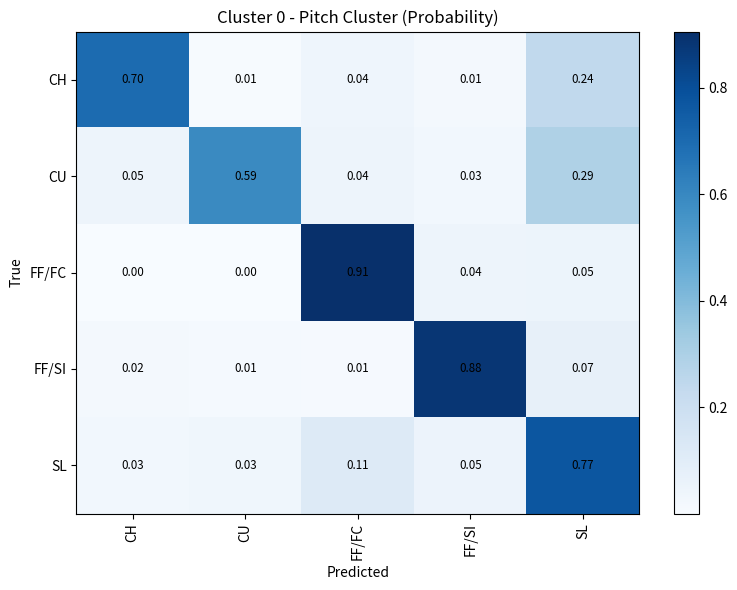

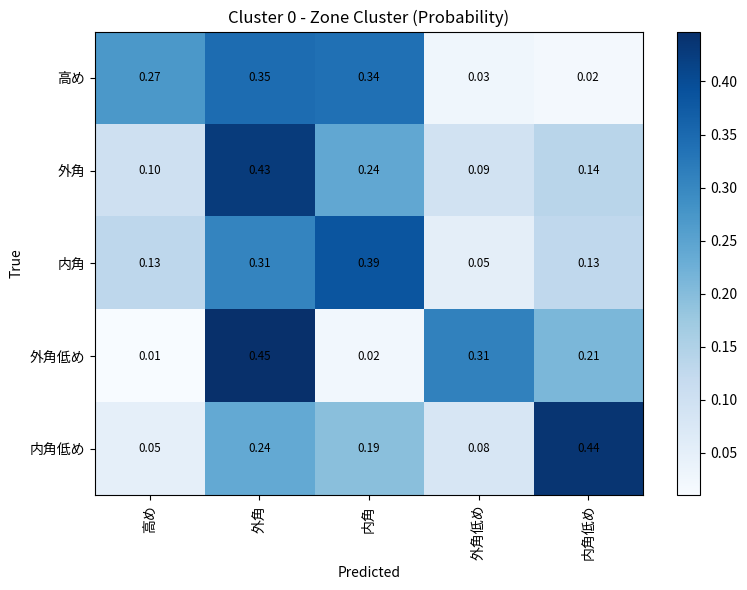

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# Zone Cluster の日本語名マップ
zone_names = {
    0: "高め",
    1: "外角",
    2: "内角",
    3: "外角低め",
    4: "内角低め"
}

# 評価対象のクラスタリスト
cluster_list = [0]

# 混同行列ファイルのマッピング
matrix_files = {
    "Pitch Cluster":   "cm_pitch_cluster_hot.csv",
    "Zone Cluster":    "cm_zone_cluster_hot.csv"
}

# 日本語フォントの指定（適宜環境に応じて変更）
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False

for cluster in cluster_list:
    dir_name = f"iohmm_allunsup"
    for title, filename in matrix_files.items():
        path = os.path.join(dir_name, filename)
        if not os.path.exists(path):
            print(f"[Cluster {cluster}] {filename} が見つかりません。スキップします。")
            continue

        df_cm = pd.read_csv(path, index_col=0)
        df_prop = df_cm.div(df_cm.sum(axis=1), axis=0).fillna(0)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(df_prop.values, aspect='auto', cmap='Blues')
        plt.colorbar(im, ax=ax)

        # 軸ラベル設定
        if title == "Zone Cluster":
            x_labels = [zone_names.get(int(c), str(c)) for c in df_prop.columns]
            y_labels = [zone_names.get(int(c), str(c)) for c in df_prop.index]
        else:
            x_labels = [str(c) for c in df_prop.columns]
            y_labels = [str(c) for c in df_prop.index]

        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Cluster {cluster} - {title} (Probability)")

        # 数値注記
        for i in range(df_prop.shape[0]):
            for j in range(df_prop.shape[1]):
                ax.text(j, i, f"{df_prop.iat[i,j]:.2f}",
                        ha="center", va="center", fontsize='small', color='black')

        plt.tight_layout()
        plt.show()


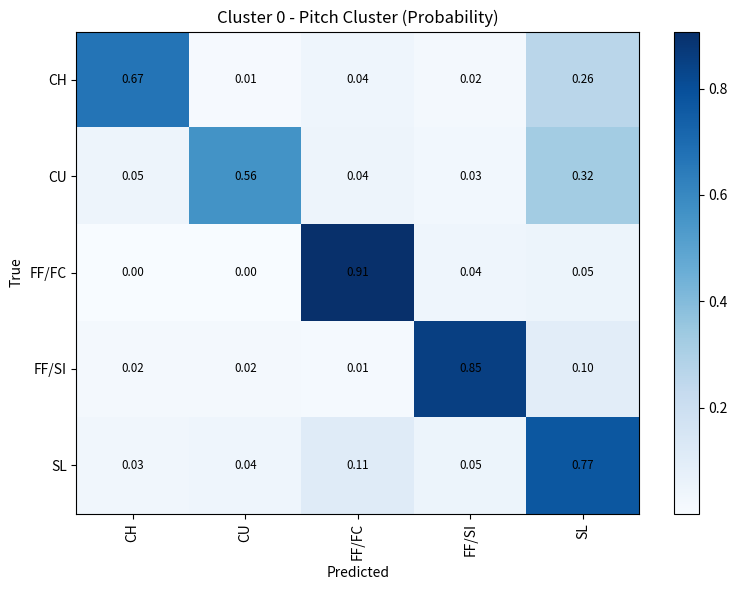

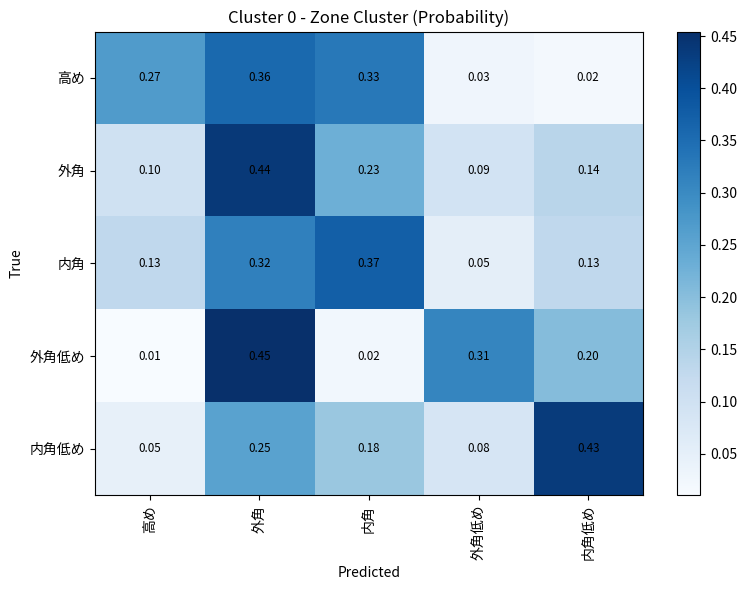

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# Zone Cluster の日本語名マップ
zone_names = {
    0: "高め",
    1: "外角",
    2: "内角",
    3: "外角低め",
    4: "内角低め"
}

pitch_names = {
    0:"CH",
    1:"CU",
    2:"FF/FC",
    3:"FF/SI",
    4:"SL"
}

# 評価対象のクラスタリスト
cluster_list = [0]

# 混同行列ファイルのマッピング
matrix_files = {
    "Pitch Cluster":   "cm_pitch_cluster_viterbi.csv",
    "Zone Cluster":    "cm_zone_cluster_viterbi.csv"
}

# 日本語フォントの指定（適宜環境に応じて変更）
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False

for cluster in cluster_list:
    dir_name = f"iohmm_allunsup"
    for title, filename in matrix_files.items():
        path = os.path.join(dir_name, filename)
        if not os.path.exists(path):
            print(f"[Cluster {cluster}] {filename} が見つかりません。スキップします。")
            continue

        df_cm = pd.read_csv(path, index_col=0)
        df_prop = df_cm.div(df_cm.sum(axis=1), axis=0).fillna(0)

        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(df_prop.values, aspect='auto', cmap='Blues')
        plt.colorbar(im, ax=ax)

        # 軸ラベル設定
        if title == "Zone Cluster":
            x_labels = [zone_names.get(int(c), str(c)) for c in df_prop.columns]
            y_labels = [zone_names.get(int(c), str(c)) for c in df_prop.index]
        elif title == "Pitch Cluster":
            x_labels = [pitch_names.get(int(c), str(c)) for c in df_prop.columns]
            y_labels = [pitch_names.get(int(c), str(c)) for c in df_prop.index]
        else:
            x_labels = [str(c) for c in df_prop.columns]
            y_labels = [str(c) for c in df_prop.index]

        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=90)
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels)

        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f"Cluster {cluster} - {title} (Probability)")

        # 数値注記
        for i in range(df_prop.shape[0]):
            for j in range(df_prop.shape[1]):
                ax.text(j, i, f"{df_prop.iat[i,j]:.2f}",
                        ha="center", va="center", fontsize='small', color='black')

        plt.tight_layout()
        plt.show()
